In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.neighbors  import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score

In [2]:
base_folder='./Data/'
universities={'cmu', 'columbia', 'gatech', 'ucla', 'uiuc', 'umich'}
universities_data={}
universities_data_frames={}

# taken from official ETS mapping: https://www.ets.org/s/toefl/pdf/linking_toefl_ibt_scores_to_ielts_scores.pdf
IELTS_TO_TOEFL_MAPPING={1:2, 1.5:2, 2:2, 2.5:2, 3:2, 3.5:2, 4:2, 4.5:3, 5:6, 5.5:11, 6:19, 6.5:23, 7:26, 7.5:27, 8:28, 8.5:29, 9:30}

# Load all data

In [3]:
for key in universities:
    with open(base_folder+key+'.json', encoding='utf-8', errors='ignore') as json_data:
        universities_data[key]=json.load(json_data, strict=False)['data']

In [4]:
for key in universities:
    universities_data_frames[key]=pd.DataFrame(universities_data[key])

# CMU EDA, Cleaning and Analysis

In [5]:
cmu_data=universities_data_frames['cmu']

cmu_data.drop('College_Affiliation', axis=1, inplace=True)
cmu_data.drop('S.No', axis=1, inplace=True)
cmu_data.drop('Term', axis=1, inplace=True)
cmu_data.drop('Old_System', axis=1, inplace=True)
cmu_data.drop('Year', axis=1, inplace=True)
cmu_data.drop('University', axis=1, inplace=True)
cmu_data.drop('Topper_Grade', axis=1, inplace=True)
cmu_data.drop('Specialization', axis=1, inplace=True)
cmu_data.drop('Student_Id', axis=1, inplace=True)
cmu_data.drop('TOEFL_Listening', axis=1, inplace=True)
cmu_data.drop('TOEFL_Writing', axis=1, inplace=True)
cmu_data.drop('TOEFL_Reading', axis=1, inplace=True)
cmu_data.drop('TOEFL_Speaking', axis=1, inplace=True)

cmu_data['GRE_AWA'][cmu_data.GRE_AWA==-1]=cmu_data['GRE_AWA'][cmu_data.GRE_AWA>=0].median()
cmu_data['GRE_Total'][cmu_data.GRE_Total<=260]=cmu_data['GRE_Total'][cmu_data.GRE_Total>=260].median()
cmu_data['GRE_Q'][cmu_data.GRE_Q<=130]=cmu_data['GRE_Q'][cmu_data.GRE_Q>=130].median()
cmu_data['GRE_V'][cmu_data.GRE_V<=130]=cmu_data['GRE_Total'][cmu_data.GRE_Total>=260].median()-cmu_data['GRE_Q'][cmu_data.GRE_Q>=130].median()
cmu_data['Publications'][cmu_data.Publications<0]=0
cmu_data.insert(5, "Normalized_Grade", cmu_data[['Grade']].div(cmu_data.Grade_Scale, axis=0).values, True) 
cmu_data.drop('Grade', axis=1, inplace=True)
cmu_data.drop('Grade_Scale', axis=1, inplace=True)

for i in range(len(cmu_data)) : 
    if(cmu_data.loc[i, 'IELTS']!=-1 and cmu_data.loc[i, 'TOEFL']==-1):
        cmu_data.loc[i, 'TOEFL']=IELTS_TO_TOEFL_MAPPING[int(cmu_data.loc[i, 'IELTS'])]*4
    elif(cmu_data.loc[i, 'IELTS']!=-1 and cmu_data.loc[i, 'TOEFL']!=-1):
        cmu_data.loc[i, 'IELTS']=max(cmu_data.loc[i, 'TOEFL'], IELTS_TO_TOEFL_MAPPING[int(cmu_data.loc[i, 'IELTS'])]*4)

cmu_data.drop('IELTS', axis=1, inplace=True)
cmu_data['TOEFL'][cmu_data.TOEFL<=0]=cmu_data['TOEFL'][cmu_data.TOEFL>0].median()
cmu_data['College_Main_Form'][cmu_data.College_Main_Form=='-1']='Not Specified'
cmu_data['Work_Experience'][cmu_data.Work_Experience<0]=0
cmu_data['Undergrad_Major'][cmu_data.Undergrad_Major=='-1']='Not Specified'

cmu_data["College_Main_Form"]=cmu_data["College_Main_Form"].astype('category')
cmu_data["College_Main_Form_Cat"]=cmu_data["College_Main_Form"].cat.codes

cmu_data["Program"]=cmu_data["Program"].astype('category')
cmu_data["Program_Cat"]=cmu_data["Program"].cat.codes

cmu_data["Status"]=cmu_data["Status"].astype('category')
cmu_data["Status_Cat"]=cmu_data["Status"].cat.codes

cmu_data["Target_Major"]=cmu_data["Target_Major"].astype('category')
cmu_data["Target_Major_Cat"]=cmu_data["Target_Major"].cat.codes

cmu_data["Undergrad_Major"]=cmu_data["Undergrad_Major"].astype('category')
cmu_data["Undergraduate_Major_Cat"]=cmu_data["Undergrad_Major"].cat.codes

print(cmu_data.columns)
print(cmu_data.shape)
print(cmu_data.iloc[626])
print(cmu_data.iloc[1])

/home/vishaal/.local/lib/python3.5/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/vishaal/.local/lib/python3.5/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/vishaal/.local/lib/python3.5/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/vishaal/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a 

Index(['College_Main_Form', 'GRE_AWA', 'GRE_Q', 'GRE_Total', 'GRE_V',
       'Normalized_Grade', 'Program', 'Publications', 'Status', 'TOEFL',
       'Target_Major', 'Undergrad_Major', 'Work_Experience',
       'College_Main_Form_Cat', 'Program_Cat', 'Status_Cat',
       'Target_Major_Cat', 'Undergraduate_Major_Cat'],
      dtype='object')
(1174, 18)
College_Main_Form            SRM University
GRE_AWA                                   4
GRE_Q                                   160
GRE_Total                               317
GRE_V                                   157
Normalized_Grade                       0.96
Program                                  MS
Publications                              6
Status                                Admit
TOEFL                                   114
Target_Major               Computer Science
Undergrad_Major            Computer Science
Work_Experience                          47
College_Main_Form_Cat                   205
Program_Cat                    

In [6]:
cmu_data.head()

,College_Main_Form,GRE_AWA,GRE_Q,GRE_Total,GRE_V,Normalized_Grade,Program,Publications,Status,TOEFL,Target_Major,Undergrad_Major,Work_Experience,College_Main_Form_Cat,Program_Cat,Status_Cat,Target_Major_Cat,Undergraduate_Major_Cat
0,"B.M.S. College of Engineering, Bangalore",4,164,315,151,0.880,MS,1,Admit,111,Software Engineering,Computer Science,18,13,1,0,7,5
1,"College of Engineering, Guindy",4,170,323,153,0.920,MS,0,Reject,111,Computer Science,Computer Science,31,37,1,1,1,5
2,Padmabhooshan Vasantdada Patil Institute of Te...,4,163,308,145,0.743,MS,1,Reject,94,Mechanical Engineering,Not Specified,30,184,1,1,6,24
3,Fr. Conceicao Rodrigues College of Engineering...,4,169,331,162,0.953,MS,1,Reject,118,Computer Science,Computer Science,0,54,1,1,1,5
4,SRM University,4,167,322,155,0.905,MS,0,Admit,114,Chemical Engineering,Chemical Engineering,6,205,1,0,0,3


In [7]:
cmu_data.tail()

,College_Main_Form,GRE_AWA,GRE_Q,GRE_Total,GRE_V,Normalized_Grade,Program,Publications,Status,TOEFL,Target_Major,Undergrad_Major,Work_Experience,College_Main_Form_Cat,Program_Cat,Status_Cat,Target_Major_Cat,Undergraduate_Major_Cat
1169,BIT Mesra,4.5,170,323,153,0.750,MS,1,Reject,114,Computer Science,Computer Science,30,17,1,1,1,5
1170,Not Specified,4.0,170,323,153,0.750,MS,1,Reject,114,Computer Science,Not Specified,25,177,1,1,1,24
1171,"BITS Pilani, Pilani Campus",3.5,170,326,156,0.760,MS,0,Reject,109,Computer Science,Computer Science,0,21,1,1,1,5
1172,Dhirubhai Ambani Institute of Information and ...,3.5,170,320,150,0.723,MS,0,Admit,110,Computer Science,Information and Communication Technology,0,47,1,0,1,17
1173,IIT Guwahati,4.0,170,325,155,0.680,MS,0,Admit,113,Computer Science,Computer Science,0,81,1,0,1,5


In [8]:
cmu_data.describe()

,GRE_AWA,GRE_Q,GRE_Total,GRE_V,Normalized_Grade,Publications,TOEFL,Work_Experience,College_Main_Form_Cat,Program_Cat,Status_Cat,Target_Major_Cat,Undergraduate_Major_Cat
count,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000
mean,3.927598,165.217206,322.086031,156.868825,0.819658,0.248722,109.669506,10.608177,139.411414,1.011925,0.687394,1.017036,8.072402
std,0.392650,3.680970,6.711718,5.254625,0.096249,0.531508,5.600646,15.446957,80.132798,0.197670,0.463753,0.279537,5.601946
min,2.500000,140.000000,280.000000,134.000000,0.520000,0.000000,82.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,163.000000,318.000000,153.000000,0.750000,0.000000,107.000000,0.000000,56.250000,1.000000,0.000000,1.000000,5.000000
50%,4.000000,166.000000,322.000000,157.000000,0.830000,0.000000,110.000000,1.000000,158.000000,1.000000,1.000000,1.000000,5.000000
75%,4.000000,168.000000,327.000000,160.000000,0.898000,0.000000,114.000000,19.000000,205.000000,1.000000,1.000000,1.000000,8.000000
max,6.000000,170.000000,339.000000,170.000000,1.000000,6.000000,120.000000,90.000000,268.000000,3.000000,1.000000,7.000000,26.000000


# Plots and Insights

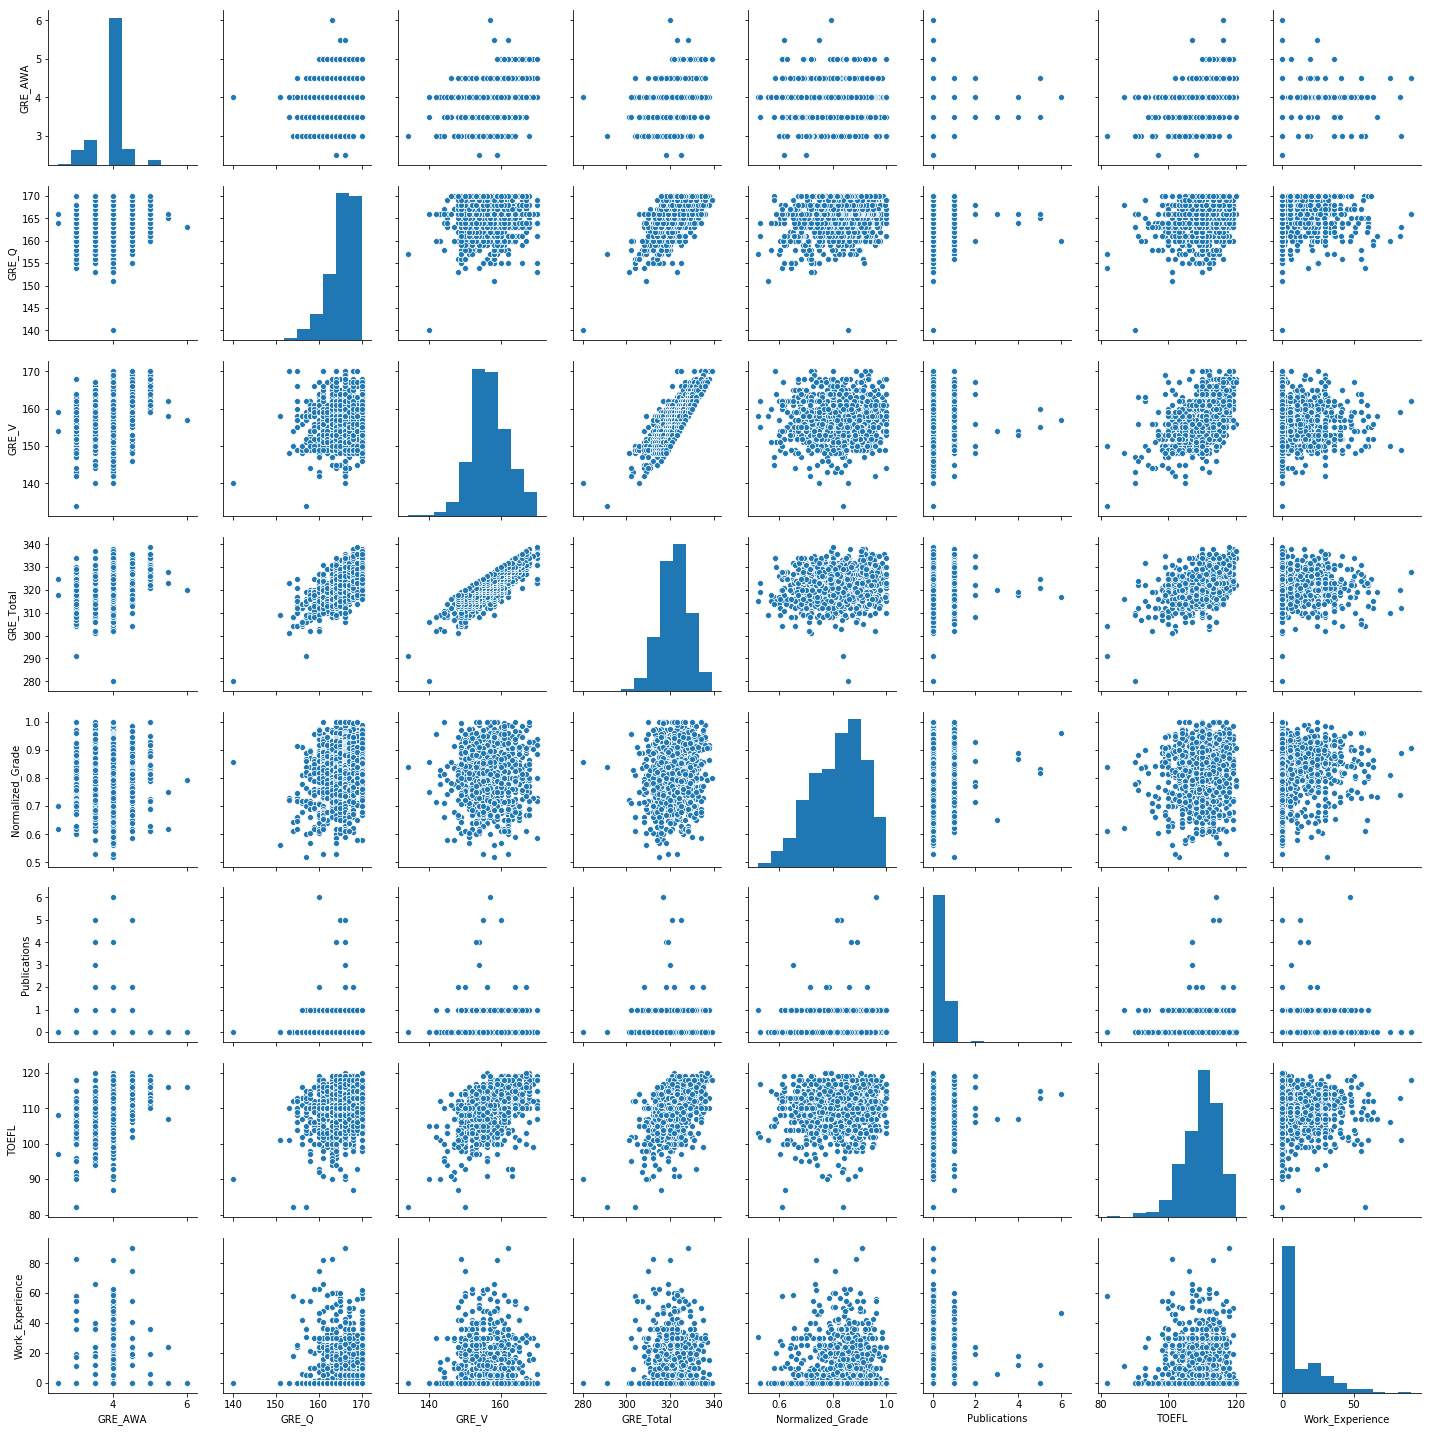

In [9]:
sns.pairplot(cmu_data.loc[0:len(cmu_data), ['GRE_AWA', 'GRE_Q', 'GRE_V', 'GRE_Total', 'Normalized_Grade', 'Publications', 'TOEFL', 'Work_Experience']])
plt.show()

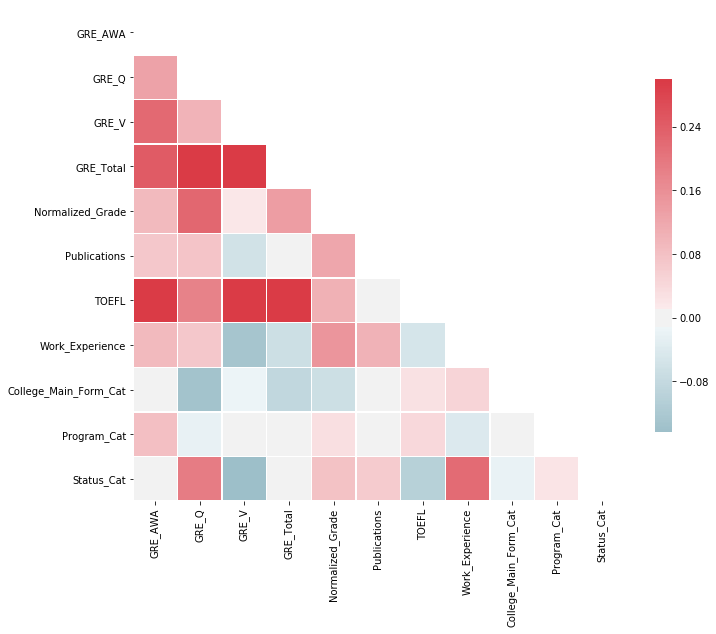

In [10]:
corr=cmu_data.loc[0:len(cmu_data), ['GRE_AWA', 'GRE_Q', 'GRE_V', 'GRE_Total', 'Normalized_Grade', 'Publications', 'TOEFL', 'Work_Experience', 'College_Main_Form_Cat', 'Program_Cat', 'Status_Cat']].corr()

mask=np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

fig, ax=plt.subplots(figsize=(11, 13))
cmap=sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

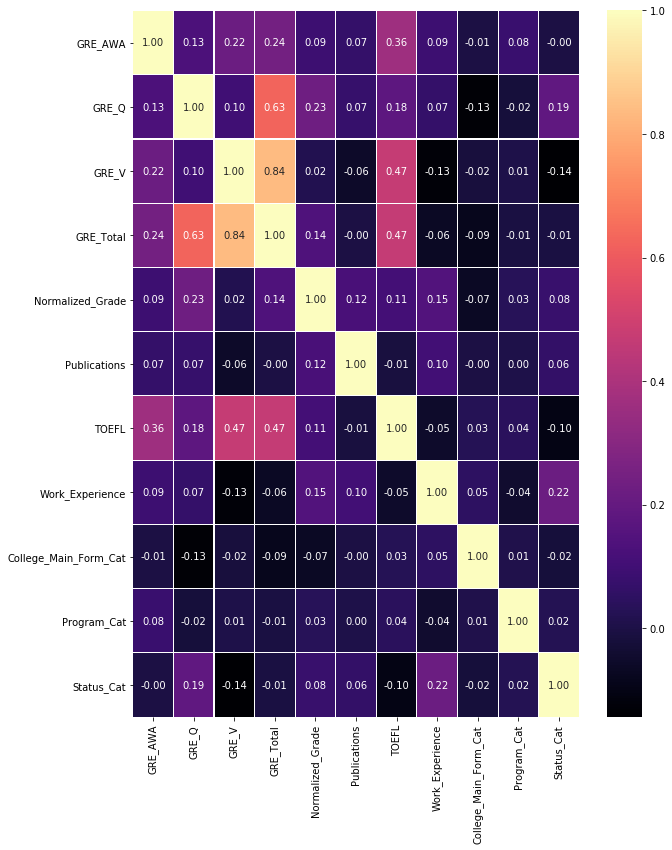

In [11]:
plt.figure(figsize=(10, 13))
sns.heatmap(cmu_data.loc[0:len(cmu_data), ['GRE_AWA', 'GRE_Q', 'GRE_V', 'GRE_Total', 'Normalized_Grade', 'Publications', 'TOEFL', 'Work_Experience', 'College_Main_Form_Cat', 'Program_Cat', 'Status_Cat']].corr(), annot=True, linewidths=0.05, fmt= '.2f',cmap="magma")
plt.show()

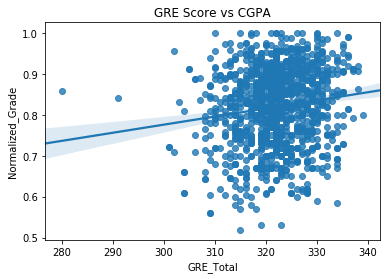

In [12]:
fig=sns.regplot(x="GRE_Total", y="Normalized_Grade", data=cmu_data)
plt.title("GRE Score vs CGPA")
plt.show()

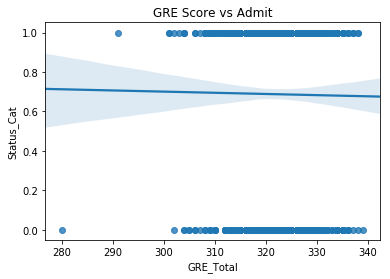

In [13]:
fig=sns.regplot(x="GRE_Total", y="Status_Cat", data=cmu_data)
plt.title("GRE Score vs Admit")
plt.show()

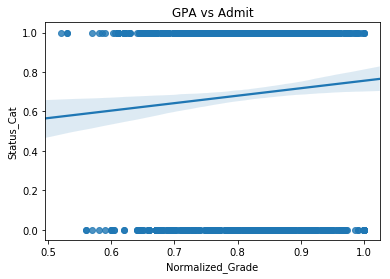

In [14]:
fig=sns.regplot(x="Normalized_Grade", y="Status_Cat", data=cmu_data)
plt.title("GPA vs Admit")
plt.show()

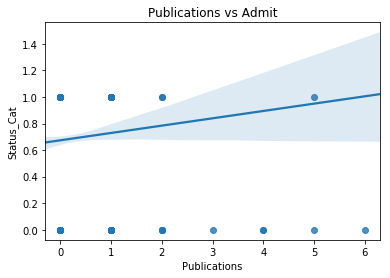

In [15]:
fig=sns.regplot(x="Publications", y="Status_Cat", data=cmu_data)
plt.title("Publications vs Admit")
plt.show()

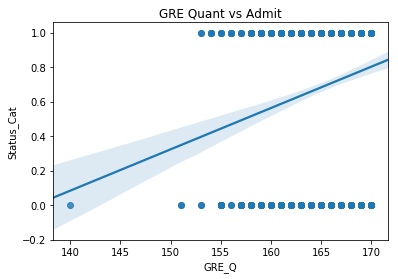

In [16]:
fig=sns.regplot(x="GRE_Q", y="Status_Cat", data=cmu_data)
plt.title("GRE Quant vs Admit")
plt.show()

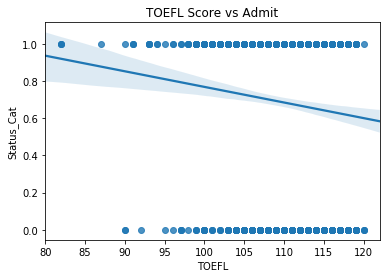

In [17]:
fig=sns.regplot(x="TOEFL", y="Status_Cat", data=cmu_data)
plt.title("TOEFL Score vs Admit")
plt.show()

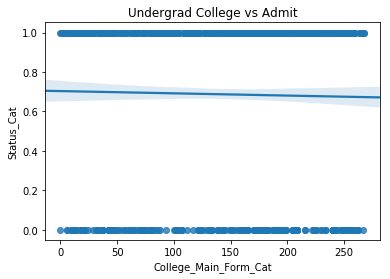

In [18]:
fig=sns.regplot(x="College_Main_Form_Cat", y="Status_Cat", data=cmu_data)
plt.title("Undergrad College vs Admit")
plt.show()

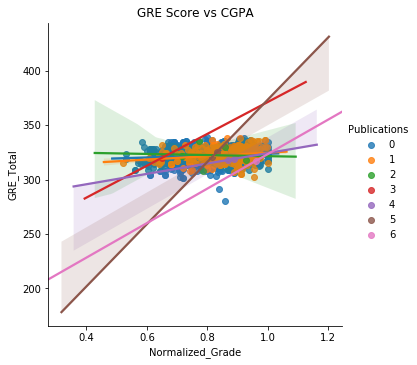

In [19]:
fig = sns.lmplot(x="Normalized_Grade", y="GRE_Total", data=cmu_data, hue="Publications")
plt.title("GRE Score vs CGPA")
plt.show()

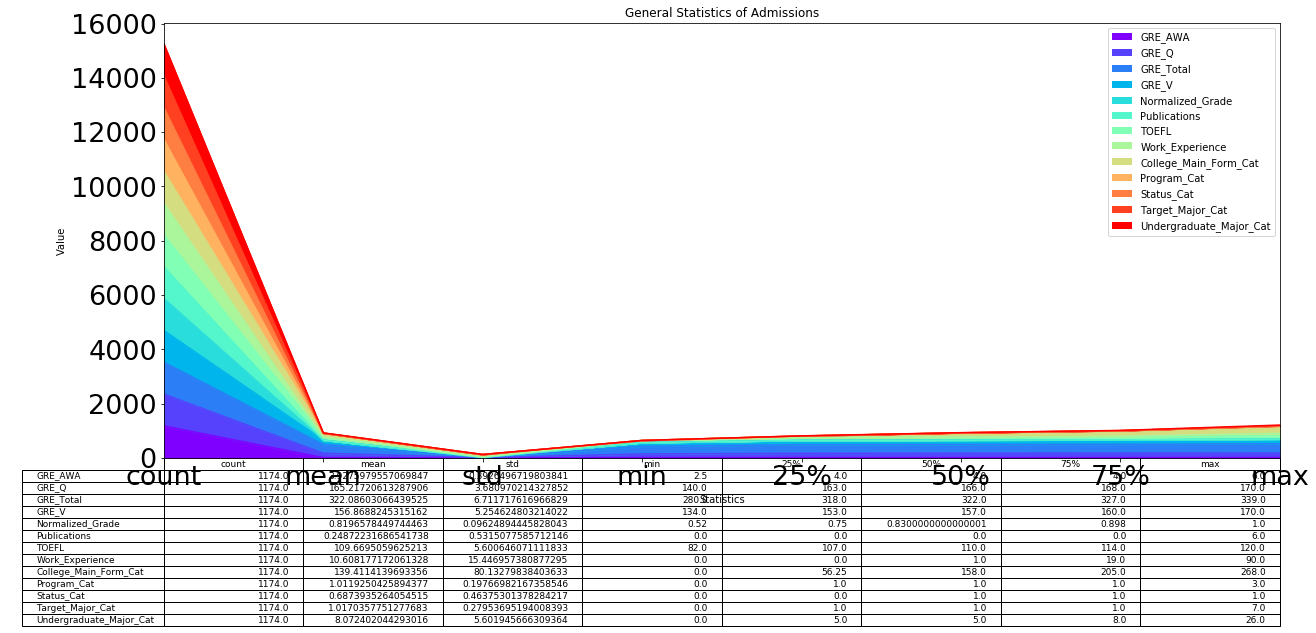

In [20]:
cmu_data.describe().plot(kind = "area",fontsize=27, figsize = (20,8), table = True,colormap="rainbow")
plt.xlabel('Statistics',)
plt.ylabel('Value')
plt.title("General Statistics of Admissions")
plt.show()

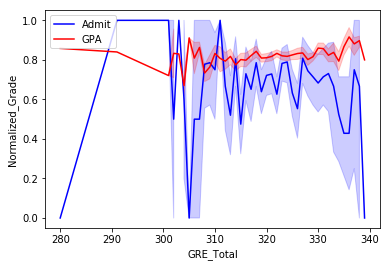

In [21]:
sns.lineplot(x="GRE_Total", y="Status_Cat", data=cmu_data,color='b',label='Admit')
sns.lineplot(x="GRE_Total", y="Normalized_Grade", data=cmu_data,color='r',label='GPA')
# sns.lineplot(x="GRE_Total", y="TOEFL", data=cmu_data,color='G',label='TOEFL')
plt.legend(loc=2)
plt.show()

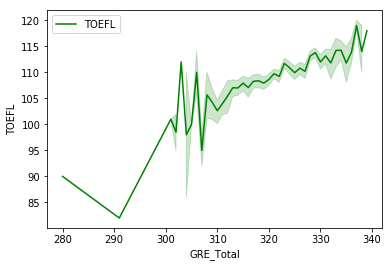

In [22]:
sns.lineplot(x="GRE_Total", y="TOEFL", data=cmu_data,color='G',label='TOEFL')
plt.legend(loc='best')
plt.show()

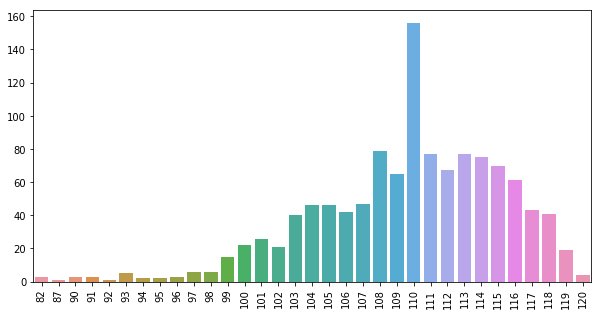

In [23]:
plt.figure(figsize=(10,5))
sns.barplot(x=cmu_data.TOEFL.value_counts().index,y=cmu_data.TOEFL.value_counts().values)
plt.xticks(rotation=90)
plt.show()

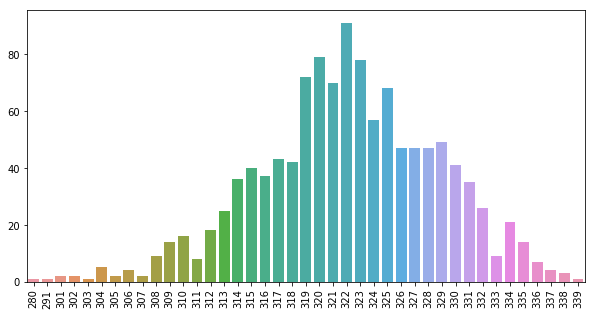

In [24]:
plt.figure(figsize=(10,5))
sns.barplot(x=cmu_data.GRE_Total.value_counts().index,y=cmu_data.GRE_Total.value_counts().values)
plt.xticks(rotation=90)
plt.show()

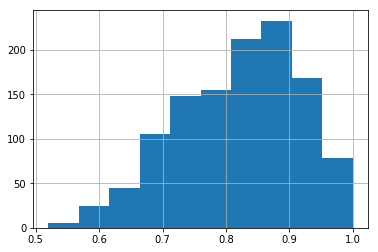

In [25]:
cmu_data.Normalized_Grade.hist()

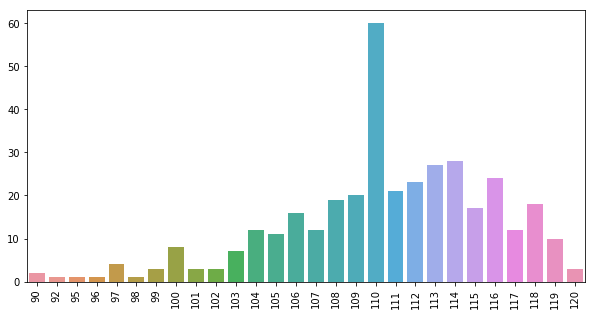

In [26]:
plt.figure(figsize=(10,5))
sns.barplot(x=cmu_data[cmu_data.Status=='Admit'].TOEFL.value_counts().index,y=cmu_data[cmu_data.Status=='Admit'].TOEFL.value_counts().values)
plt.xticks(rotation=90)
plt.show()

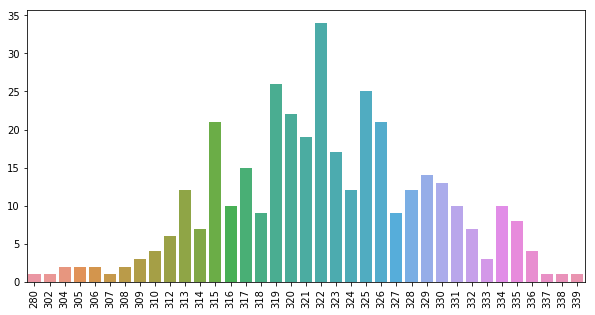

In [27]:
plt.figure(figsize=(10,5))
sns.barplot(x=cmu_data[cmu_data.Status=='Admit'].GRE_Total.value_counts().index,y=cmu_data[cmu_data.Status=='Admit'].GRE_Total.value_counts().values)
plt.xticks(rotation=90)
plt.show()

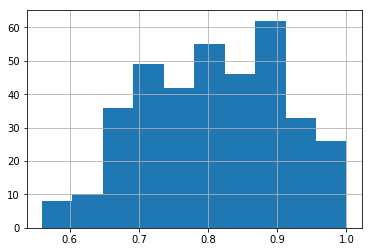

In [28]:
cmu_data[cmu_data.Status=='Admit'].Normalized_Grade.hist()

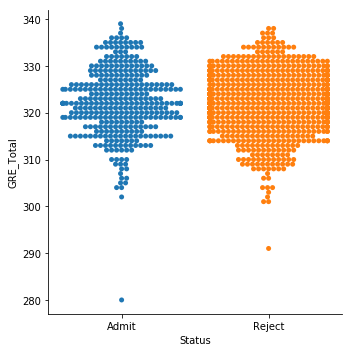

In [32]:
sns.catplot(x="Status", y="GRE_Total", kind="swarm", data=cmu_data)

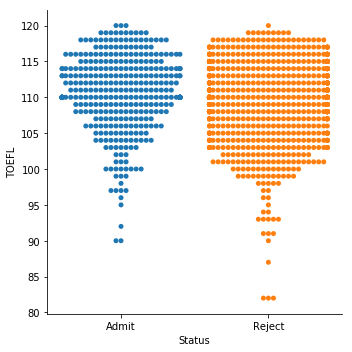

In [495]:
sns.catplot(x="Status", y="TOEFL", kind="swarm", data=cmu_data)

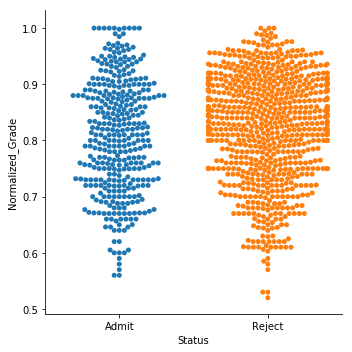

In [496]:
sns.catplot(x="Status", y="Normalized_Grade", kind="swarm", data=cmu_data)

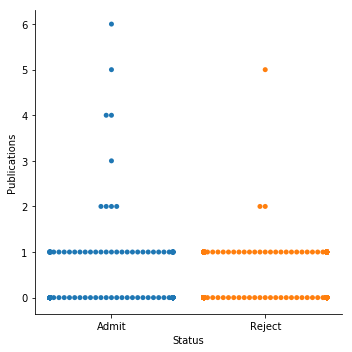

In [497]:
sns.catplot(x="Status", y="Publications", kind="swarm", data=cmu_data)

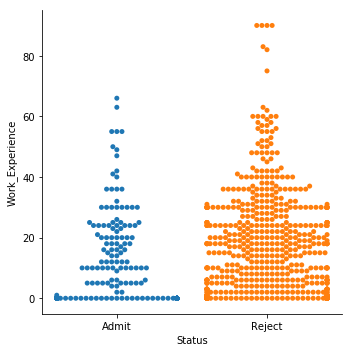

In [498]:
sns.catplot(x="Status", y="Work_Experience", kind="swarm", data=cmu_data)

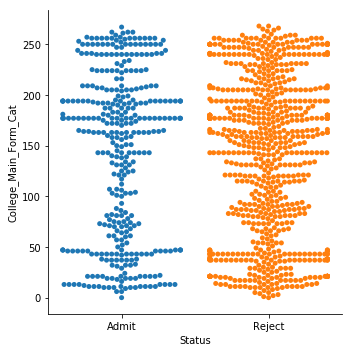

In [506]:
sns.catplot(x="Status", y="College_Main_Form_Cat", kind="swarm", data=cmu_data)

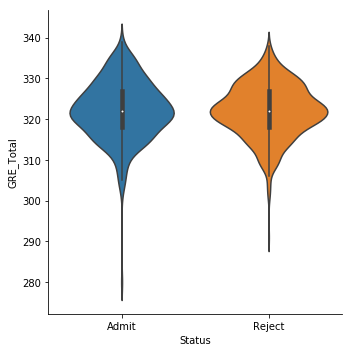

In [499]:
sns.catplot(x="Status", y="GRE_Total", kind='violin', data=cmu_data)

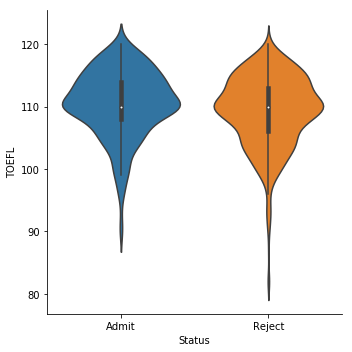

In [500]:
sns.catplot(x="Status", y="TOEFL", kind='violin', data=cmu_data)

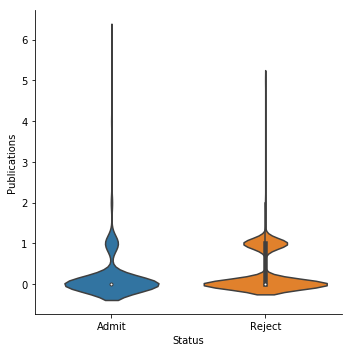

In [501]:
sns.catplot(x="Status", y="Publications", kind='violin', data=cmu_data)

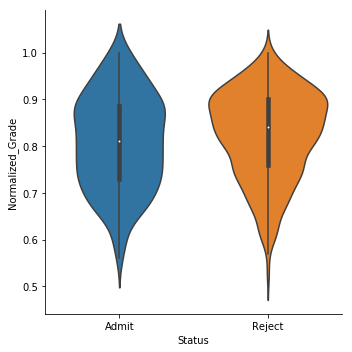

In [502]:
sns.catplot(x="Status", y="Normalized_Grade", kind='violin', data=cmu_data)

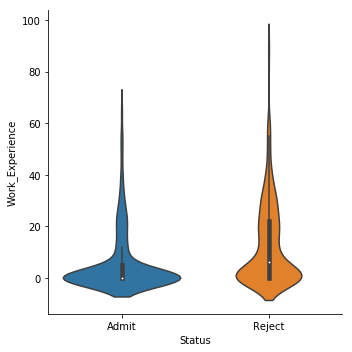

In [503]:
sns.catplot(x="Status", y="Work_Experience", kind='violin', data=cmu_data)

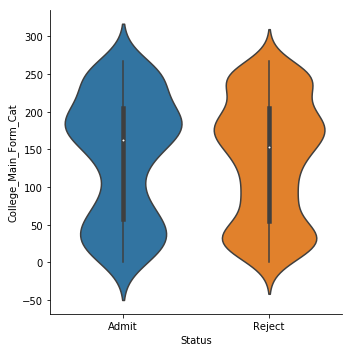

In [505]:
sns.catplot(x="Status", y="College_Main_Form_Cat", kind='violin', data=cmu_data)

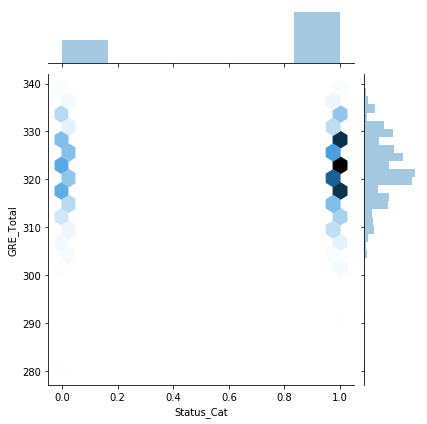

In [510]:
sns.jointplot("Status_Cat", "GRE_Total", data=cmu_data, kind='hex')

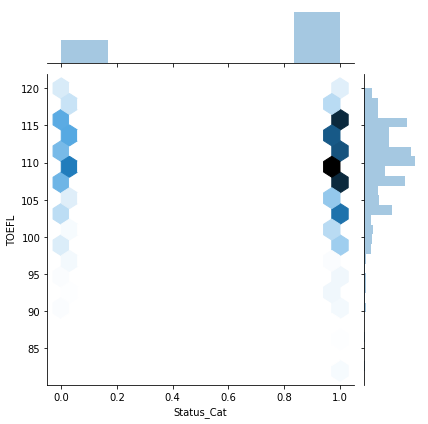

In [512]:
sns.jointplot("Status_Cat", "TOEFL", data=cmu_data, kind='hex')

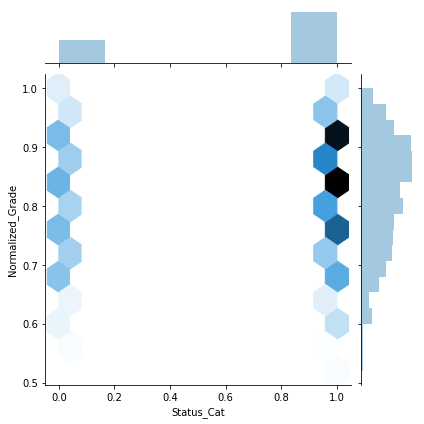

In [514]:
sns.jointplot("Status_Cat", "Normalized_Grade", data=cmu_data, kind='hex')

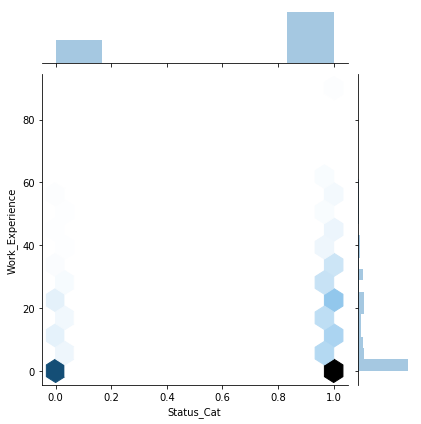

In [515]:
sns.jointplot("Status_Cat", "Work_Experience", data=cmu_data, kind='hex')

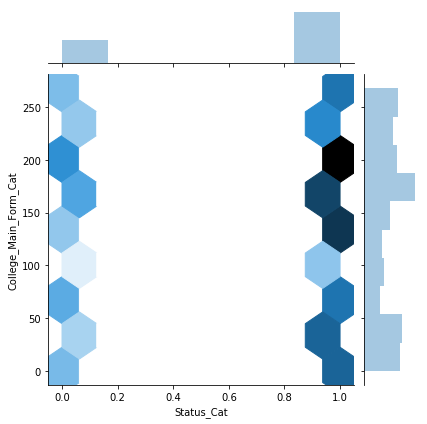

In [516]:
sns.jointplot("Status_Cat", "College_Main_Form_Cat", data=cmu_data, kind='hex')

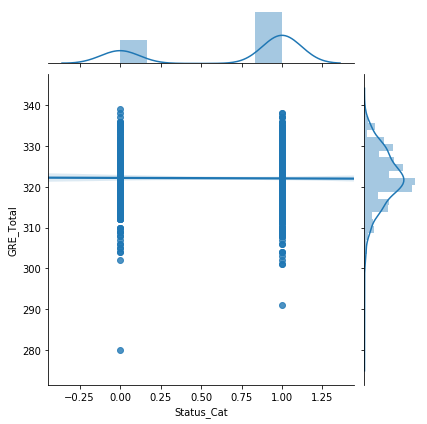

In [511]:
sns.jointplot("Status_Cat", "GRE_Total", data=cmu_data, kind='reg')

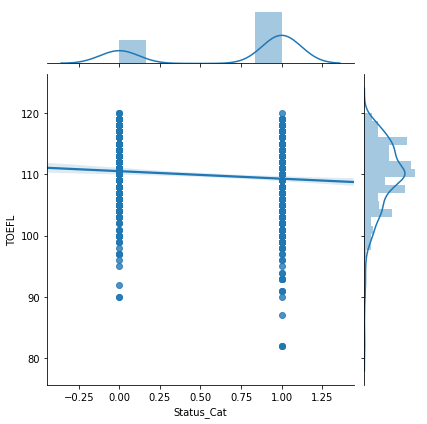

In [517]:
sns.jointplot("Status_Cat", "TOEFL", data=cmu_data, kind='reg')

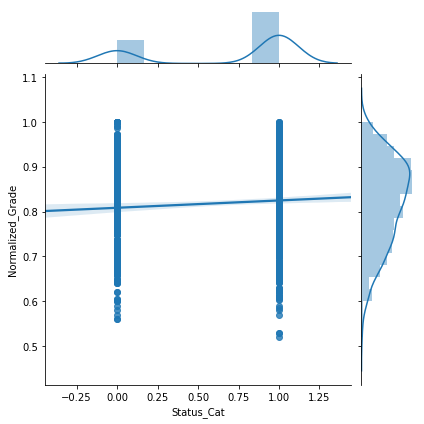

In [518]:
sns.jointplot("Status_Cat", "Normalized_Grade", data=cmu_data, kind='reg')

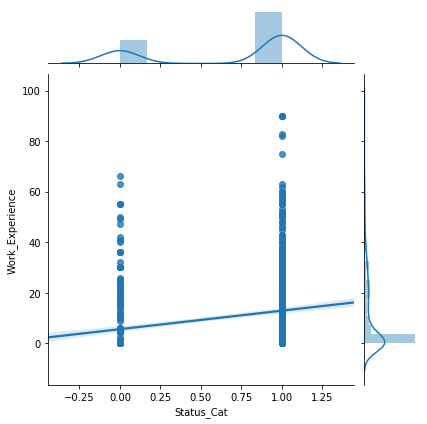

In [519]:
sns.jointplot("Status_Cat", "Work_Experience", data=cmu_data, kind='reg')

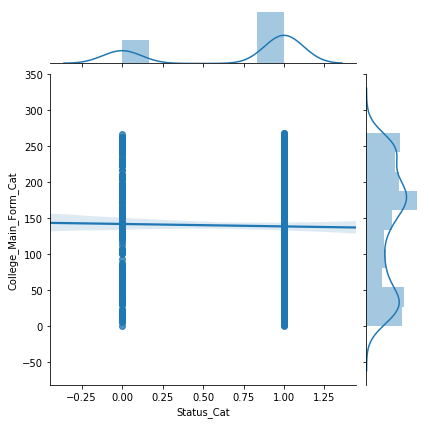

In [520]:
sns.jointplot("Status_Cat", "College_Main_Form_Cat", data=cmu_data, kind='reg')

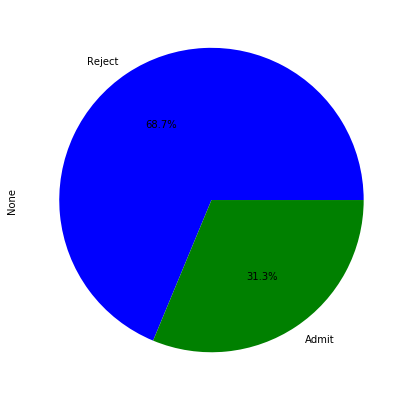

In [522]:
plt.figure(1, figsize=(7,7))
cmu_data['Status'].value_counts().plot.pie(autopct="%1.1f%%")
plt.show()

# Classification of Admits/Rejects

In [605]:
cmu_data.head()

data_X=cmu_data.loc[0:len(cmu_data), ['GRE_AWA', 'GRE_Q', 'GRE_V', 'GRE_Total', 'Normalized_Grade', 'Program_Cat', 'Publications', 'Target_Major_Cat', 'Work_Experience']]
data_X.insert(5, "Undergraduate_Major_Cat", cmu_data.Undergraduate_Major_Cat.values, True) 
data_Y=cmu_data['Status_Cat']

print(data_X.shape, data_Y.shape)

(1174, 10) (1174,)


In [626]:
def plot_roc(false_positive_rate, true_positive_rate, roc_auc):
    plt.figure(figsize=(5,5))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],linestyle='--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def plot_feature_importances(model, X_train, labels):
    n_features=X_train.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), labels=labels)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

In [627]:
X_train, X_test, Y_train, Y_test=train_test_split(data_X, data_Y, test_size=0.2)
X_train, X_test, Y_train, Y_test=np.asarray(X_train), np.asarray(X_test), np.asarray(Y_train), np.asarray(Y_test)

X_train=preprocessing.scale(X_train)
X_test=preprocessing.scale(X_test)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(939, 10) (235, 10) (939,) (235,)


0.7276595744680852
              precision    recall  f1-score   support

           0       0.59      0.25      0.35        69
           1       0.75      0.93      0.83       166

   micro avg       0.73      0.73      0.73       235
   macro avg       0.67      0.59      0.59       235
weighted avg       0.70      0.73      0.69       235

0.724174653887114
              precision    recall  f1-score   support

           0       0.66      0.27      0.38       298
           1       0.73      0.93      0.82       641

   micro avg       0.72      0.72      0.72       939
   macro avg       0.70      0.60      0.60       939
weighted avg       0.71      0.72      0.68       939



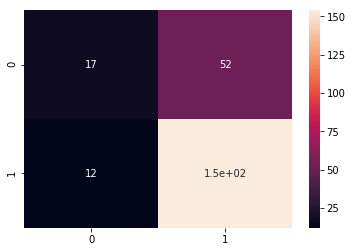

In [639]:
log_reg_classifier=LogisticRegression(solver='lbfgs', penalty='l2').fit(X_train, Y_train)
test_preds=log_reg_classifier.predict(X_test)
train_preds=log_reg_classifier.predict(X_train)

print(accuracy_score(Y_test, test_preds))
print(classification_report(Y_test, test_preds))
print(accuracy_score(Y_train, train_preds))
print(classification_report(Y_train, train_preds))
cm=confusion_matrix(Y_test, test_preds)
sns.heatmap(cm,annot=True)

0.6553191489361702
              precision    recall  f1-score   support

           0       0.38      0.29      0.33        69
           1       0.73      0.81      0.77       166

   micro avg       0.66      0.66      0.66       235
   macro avg       0.56      0.55      0.55       235
weighted avg       0.63      0.66      0.64       235

0.8881789137380192
              precision    recall  f1-score   support

           0       0.86      0.78      0.81       298
           1       0.90      0.94      0.92       641

   micro avg       0.89      0.89      0.89       939
   macro avg       0.88      0.86      0.87       939
weighted avg       0.89      0.89      0.89       939



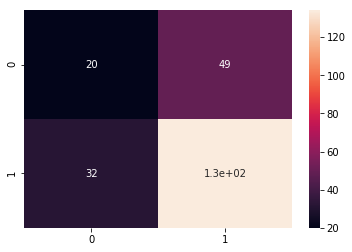

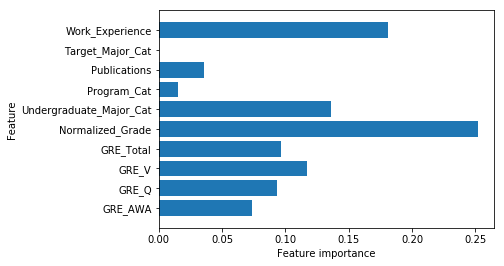

In [641]:
dt_classifier=DecisionTreeClassifier(max_depth=10).fit(X_train, Y_train)
test_preds=dt_classifier.predict(X_test)
train_preds=dt_classifier.predict(X_train)

print(accuracy_score(Y_test, test_preds))
print(classification_report(Y_test, test_preds))
print(accuracy_score(Y_train, train_preds))
print(classification_report(Y_train, train_preds))
cm=confusion_matrix(Y_test, test_preds)
sns.heatmap(cm,annot=True)

plt.figure()
plot_feature_importances(dt_classifier, X_train, labels=['GRE_AWA', 'GRE_Q', 'GRE_V', 'GRE_Total', 'Normalized_Grade', 'Undergraduate_Major_Cat', 'Program_Cat', 'Publications', 'Target_Major_Cat', 'Work_Experience'])

0.7063829787234043
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        69
           1       0.71      1.00      0.83       166

   micro avg       0.71      0.71      0.71       235
   macro avg       0.35      0.50      0.41       235
weighted avg       0.50      0.71      0.58       235

0.7050053248136315
              precision    recall  f1-score   support

           0       0.77      0.10      0.18       298
           1       0.70      0.99      0.82       641

   micro avg       0.71      0.71      0.71       939
   macro avg       0.74      0.54      0.50       939
weighted avg       0.72      0.71      0.62       939



/home/vishaal/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


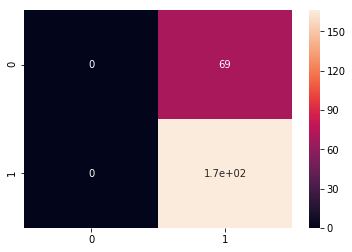

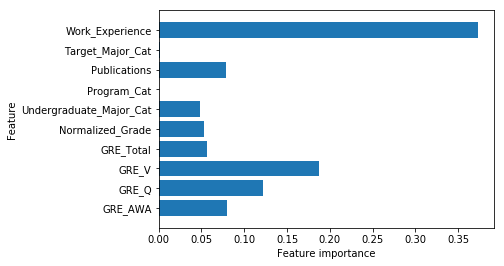

In [642]:
rf_classifier=RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0).fit(X_train, Y_train)
test_preds=rf_classifier.predict(X_test)
train_preds=rf_classifier.predict(X_train)

print(accuracy_score(Y_test, test_preds))
print(classification_report(Y_test, test_preds))
print(accuracy_score(Y_train, train_preds))
print(classification_report(Y_train, train_preds))
cm=confusion_matrix(Y_test, test_preds)
sns.heatmap(cm,annot=True)

plt.figure()
plot_feature_importances(rf_classifier, X_train, labels=['GRE_AWA', 'GRE_Q', 'GRE_V', 'GRE_Total', 'Normalized_Grade', 'Undergraduate_Major_Cat', 'Program_Cat', 'Publications', 'Target_Major_Cat', 'Work_Experience'])

0.6680851063829787
              precision    recall  f1-score   support

           0       0.33      0.13      0.19        69
           1       0.71      0.89      0.79       166

   micro avg       0.67      0.67      0.67       235
   macro avg       0.52      0.51      0.49       235
weighted avg       0.60      0.67      0.61       235

0.9925452609158679
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       298
           1       0.99      1.00      0.99       641

   micro avg       0.99      0.99      0.99       939
   macro avg       0.99      0.99      0.99       939
weighted avg       0.99      0.99      0.99       939



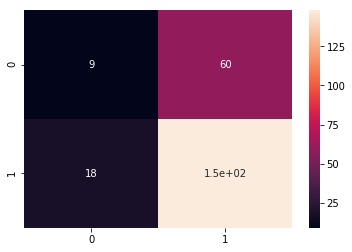

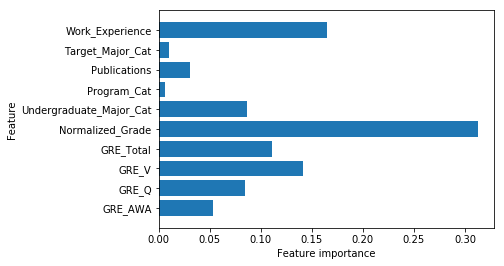

In [643]:
gbm_classifier=GradientBoostingClassifier(loss='exponential', n_estimators=1000).fit(X_train, Y_train)
test_preds=gbm_classifier.predict(X_test)
train_preds=gbm_classifier.predict(X_train)

print(accuracy_score(Y_test, test_preds))
print(classification_report(Y_test, test_preds))
print(accuracy_score(Y_train, train_preds))
print(classification_report(Y_train, train_preds))
cm=confusion_matrix(Y_test, test_preds)
sns.heatmap(cm,annot=True)

plt.figure()
plot_feature_importances(gbm_classifier, X_train, labels=['GRE_AWA', 'GRE_Q', 'GRE_V', 'GRE_Total', 'Normalized_Grade', 'Undergraduate_Major_Cat', 'Program_Cat', 'Publications', 'Target_Major_Cat', 'Work_Experience'])

0.7021276595744681
              precision    recall  f1-score   support

           0       0.48      0.22      0.30        69
           1       0.74      0.90      0.81       166

   micro avg       0.70      0.70      0.70       235
   macro avg       0.61      0.56      0.56       235
weighted avg       0.66      0.70      0.66       235

0.7497337593184239
              precision    recall  f1-score   support

           0       0.78      0.30      0.43       298
           1       0.75      0.96      0.84       641

   micro avg       0.75      0.75      0.75       939
   macro avg       0.76      0.63      0.63       939
weighted avg       0.76      0.75      0.71       939



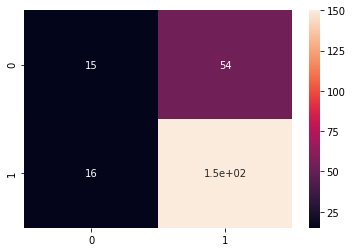

In [644]:
svm_classifier=SVC(gamma='auto', C=1).fit(X_train, Y_train)
test_preds=svm_classifier.predict(X_test)
train_preds=svm_classifier.predict(X_train)

print(accuracy_score(Y_test, test_preds))
print(classification_report(Y_test, test_preds))
print(accuracy_score(Y_train, train_preds))
print(classification_report(Y_train, train_preds))
cm=confusion_matrix(Y_test, test_preds)
sns.heatmap(cm,annot=True)